**Общая информация**

**Срок сдачи:** 13 марта 2017, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 13 марта, -4 балла после 06:00 20 марта, -6 баллов после 06:00 27 марта

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий в slack @alkhamush

Необходимо в slack создать таск в приватный чат:
/todo Фамилия Имя ссылка на гитхаб @alkhamush
Пример:
/todo Ксения Стройкова https://github.com/stroykova/spheremailru/stroykova_hw1.ipynb @alkhamush

Используйте данный Ipython Notebook при оформлении домашнего задания.

###### Задание 1 (2 баллов)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. Самостоятельно разберитесь, как считается score из KNeighborsClassifier и реализуйте аналог в своём классе.

###### Задание 2 (2 балла)
Добиться скорости работы на fit,  predict и predict_proba сравнимой со sklearn 4 балла для iris и mnist
Для этого используем numpy

###### Задание 3 (2 балла)
Для iris найдите такой параметр n_neighbors, при котором выдаётся наилучший score. Нарисуйте график зависимости score от n_neighbors

###### Задание 3 (2 балла)
Выполнить требования pep8

###### Задание 5 (2 балла)
Описать для чего нужны следующие библиотеки/классы/функции (список будет ниже)


In [2]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets
from sklearn.base import ClassifierMixin
from sklearn.datasets import fetch_mldata
from sklearn.neighbors.base import \
    NeighborsBase, KNeighborsMixin,\
    RadiusNeighborsMixin, SupervisedIntegerMixin
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [3]:
def pairwise_distances(X, Y):
    """Функция, считающая попарные расстояния между строчками матриц X, Y.

    Идейно должна лежать в каком-нибудь отдельном файле типа untils.py.
    """

    x_dist = (X ** 2).sum(axis=1)
    y_dist = (Y ** 2).sum(axis=1)
    xy_dist = X.dot(Y.T)
    dist = -2 * xy_dist + y_dist + x_dist.reshape(-1, 1)

    """Из математических соображений не могло получиться отрицательных
    значений, поэтому обнулим их, чтобы не возникало ошибок."""
    return np.sqrt(np.where(dist < 0, 0, dist))


class MyKNeighborsClassifier(NeighborsBase, KNeighborsMixin,
                             SupervisedIntegerMixin, ClassifierMixin):

    """Данный класс представляет собой реализацию метода ближайших соседей.

    В качестве основной метрики используется евклидова метрика.
    """

    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors

    def fit(self, X, y):
        """Обучаем выборку.
            В качестве train data берем X.
            В качестве target values берем y.

            Требования к X -- numpy.ndarray размерности не более двух.
            Требования к y -- numpy.ndarray размерности 1.
            """

        isXarr = isinstance(X, np.ndarray)
        isyarr = isinstance(y, np.ndarray)
        if not (isXarr and isyarr) or X.ndim > 2 or y.ndim != 1:
            raise Exception('Wrong format of X,y')

        if X.ndim == 1:
            self.X_ = X.reshape(X.shape[0], 1)
        else:
            self.X_ = X

        self.y_ = y
        self.classes_ = np.unique(y)

    def _row_mode(self, X):
        """Функция, считающая моду по строчкам"""

        row_mode = np.array(self.classes_[0]).repeat(X.shape[0])
        class_count = np.zeros(X.shape[0]) - 1
        for cur_class in self.classes_:
            cur_class_count = np.sum(cur_class == X, axis=1)
            row_mode = np.where(class_count < cur_class_count,
                                cur_class, row_mode)
            class_count = np.where(class_count < cur_class_count,
                                   cur_class_count, class_count)
        return row_mode

    def predict(self, X):
        """Predict the class labels for the provided data

        Parameters
        ----------
        X : array-like, shape (n_query, n_features),
            Test samples.

        Returns
        -------
        y : array of shape [n_samples]
            Class labels for each data sample.
        """

        isXarr = isinstance(X, np.ndarray)
        if not isXarr or X.ndim != 2 or X.shape[1] != self.X_.shape[1]:
            raise Exception('Wrong format of X')

        classesNeighbors = self._getKNeighborsClasses(X)
        return self._row_mode(classesNeighbors)

    def predict_proba(self, X):
        classesNeighbors = self._getKNeighborsClasses(X)

        probs = []
        for cur_class in self.classes_:
            probs.append(np.sum(cur_class == classesNeighbors, axis=1))

        return np.array(probs).T / self.n_neighbors

    def score(self, X, y):
        return np.average(self.predict(X) == y)

    def _getKNeighborsClasses(self, X, n_neighbors=None):
        """Функция возвращает классы k ближайших соседей"""

        if n_neighbors is None:
            n_neighbors = self.n_neighbors

        pairwise_dist = pairwise_distances(X, self.X_)
        neigborsIndexes = np.argsort(pairwise_dist, axis=1)[:, : n_neighbors]
        return self.y_[neigborsIndexes]

**IRIS**

In [3]:
iris = datasets.load_iris()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [5]:
clf = KNeighborsClassifier(n_neighbors=4)
my_clf = MyKNeighborsClassifier(n_neighbors=4)

In [6]:
%time clf.fit(X_train, y_train)

CPU times: user 1 ms, sys: 261 µs, total: 1.26 ms
Wall time: 1.11 ms


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=4, p=2,
           weights='uniform')

In [7]:
%time my_clf.fit(X_train, y_train)

CPU times: user 97 µs, sys: 62 µs, total: 159 µs
Wall time: 124 µs


In [8]:
%time clf.predict(X_test)

CPU times: user 993 µs, sys: 242 µs, total: 1.23 ms
Wall time: 1.08 ms


array([0, 1, 1, 1, 0, 2, 2, 0, 2, 2, 1, 0, 1, 0, 1])

In [9]:
%time my_clf.predict(X_test)

CPU times: user 986 µs, sys: 637 µs, total: 1.62 ms
Wall time: 1.37 ms


array([0, 1, 1, 1, 0, 2, 2, 0, 2, 2, 1, 0, 1, 0, 1])

In [10]:
%time clf.predict_proba(X_test)

CPU times: user 934 µs, sys: 216 µs, total: 1.15 ms
Wall time: 1.01 ms


array([[1.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  ],
       [0.  , 1.  , 0.  ],
       [0.  , 1.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [0.  , 0.  , 1.  ],
       [0.  , 0.  , 1.  ],
       [1.  , 0.  , 0.  ],
       [0.  , 0.  , 1.  ],
       [0.  , 0.25, 0.75],
       [0.  , 1.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  ]])

In [11]:
%time my_clf.predict_proba(X_test)

CPU times: user 693 µs, sys: 262 µs, total: 955 µs
Wall time: 756 µs


array([[1.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  ],
       [0.  , 1.  , 0.  ],
       [0.  , 1.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [0.  , 0.  , 1.  ],
       [0.  , 0.  , 1.  ],
       [1.  , 0.  , 0.  ],
       [0.  , 0.  , 1.  ],
       [0.  , 0.25, 0.75],
       [0.  , 1.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  ]])

In [12]:
clf.score(X_test, y_test)

0.9333333333333333

In [13]:
my_clf.score(X_test, y_test)

0.9333333333333333

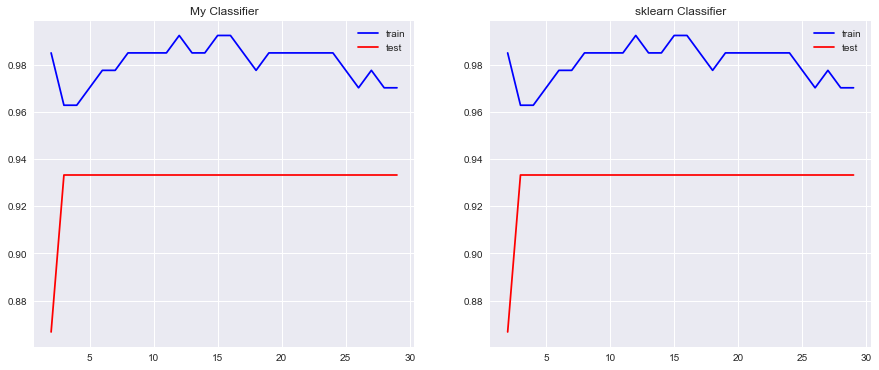



Максимальное значение score на тестовой выборке достигается при количестве соседей равным
 [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
 27 28 29]
Максимальное значение score на тренировочной выборке достигается при количестве соседей равным
 [12 15 16]


In [14]:
# Задание 3

"""Списки ошибок для моего классификатора"""
errors_train_my = []
errors_test_my = []

"""Списки ошибок для библиотечного классификатора"""
errors_train = []
errors_test = []

neighbors_range = range(2, 30)
for k in neighbors_range:

    """My Classifier"""

    my_knn = MyKNeighborsClassifier(k)
    my_knn.fit(X_train, y_train)

    errors_train_my.append(my_knn.score(X_train, y_train))
    errors_test_my.append(my_knn.score(X_test, y_test))

    """sklearn Classifier"""

    knn = MyKNeighborsClassifier(k)
    knn.fit(X_train, y_train)

    errors_train.append(knn.score(X_train, y_train))
    errors_test.append(knn.score(X_test, y_test))

"""Рисуем график для My Classifier"""
plt.subplot(1, 2, 1)
plt.plot(neighbors_range, errors_train_my, color='blue', label='train')
plt.plot(neighbors_range, errors_test_my, color='red', label='test')
plt.title('My Classifier')
plt.legend()

"""Рисуем график для sklearn Classifier"""
plt.subplot(1, 2, 2)
plt.plot(neighbors_range, errors_train, color='blue', label='train')
plt.plot(neighbors_range, errors_test, color='red', label='test')
plt.title('sklearn Classifier')
plt.legend()
fig = plt.gcf()
fig.set_size_inches(15, 6, forward=True)
plt.show()

"""Выводим лучшие показатели количества соседей"""
neighbors_range = np.array(neighbors_range)
mask_argmaxes_test = np.abs(errors_test - max(errors_test)) < 1e-10
argmaxes_test = neighbors_range[mask_argmaxes_test]

mask_argmaxes_train = np.abs(errors_train - max(errors_train)) < 1e-10
argmaxes_train = neighbors_range[mask_argmaxes_train]
print("\n\nМаксимальное значение score на тестовой выборке "
      "достигается при количестве соседей равным\n", argmaxes_test)
print("Максимальное значение score на тренировочной выборке "
      "достигается при количестве соседей равным\n", argmaxes_train)

**MNIST**

In [ ]:
mnist = fetch_mldata('MNIST original')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(mnist.data, mnist.target, test_size=0.1, stratify=mnist.target)

In [4]:
"""К сожалению, у меня не заработала fetch_mldata, поэтому использовал следующий
код для работы с данными. Для его выполнения должен стоять пакет tensorflow.
"""

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/")

data = np.concatenate((mnist.train.images, mnist.test.images, mnist.validation.images), axis = 0)
target = np.concatenate((mnist.train.labels, mnist.test.labels, mnist.validation.labels), axis = 0)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [5]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.1, stratify=target)

In [6]:
clf = KNeighborsClassifier(n_neighbors=2)
my_clf = MyKNeighborsClassifier(n_neighbors=2)

In [7]:
%time clf.fit(X_train, y_train)

CPU times: user 36 s, sys: 655 ms, total: 36.6 s
Wall time: 38.9 s


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=2, p=2,
           weights='uniform')

In [8]:
%time my_clf.fit(X_train, y_train)

CPU times: user 2.23 ms, sys: 1.49 ms, total: 3.72 ms
Wall time: 1.91 ms


In [9]:
%time clf.predict(X_test)

CPU times: user 9min 5s, sys: 4.11 s, total: 9min 9s
Wall time: 9min 24s


array([8, 3, 3, ..., 5, 0, 3], dtype=uint8)

In [10]:
%time my_clf.predict(X_test)

CPU times: user 1min 1s, sys: 17.7 s, total: 1min 18s
Wall time: 1min 17s


array([8, 3, 3, ..., 5, 0, 3], dtype=uint8)

In [11]:
%time clf.predict_proba(X_test)

CPU times: user 8min 47s, sys: 3.8 s, total: 8min 51s
Wall time: 8min 58s


array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [12]:
%time my_clf.predict_proba(X_test)

CPU times: user 59.7 s, sys: 13.7 s, total: 1min 13s
Wall time: 1min 7s


array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [13]:
clf.score(X_test, y_test)

0.9675714285714285

In [14]:
my_clf.score(X_test, y_test)

0.9675714285714285

Задание 5

In [ ]:
# seaborn
'''
Seaborn - это питоновская библиотека для визуалиции данных, имеющая в 
качестве основы matplotlib. Представляет собой высокоуровневый инструмент 
для рисования привлекательных статистических графиков. 
'''

# matplotlib
'''
Matplotlib - это питоновская библитека для создания 2D изображений графиков, 
различного рода фигур и интерактивных окружений. 
'''

# train_test_split
'''
Разбивает массив данных или матрицу на тренировочное и тестовое подмножества.
'''

# Pipelin%load_ext e (from sklearn.pipeline import Pipeline)
'''
Pipeline может быть использован, чтобы соединить несколько алгоритмов (или методов) в один.
Pipeline - вещь нужная, так как часто существует вполне определенная последовательность щагов в обработке
данных, например, отбор значимых признаков, нормировка и классификация. 
'''

# StandardScaler (from sklearn.preprocessing import StandardScaler)
'''
StandardScaler нужен для стандартизации признаков. Алгоритм прост: вычитаем среднее
и нормируем до единичной дисперсии.
'''

# ClassifierMixin
'''
Класс - "примесь" с одним методом score. Нужен для подсчета числовой характеристики 
работоспособности метода классификации. 
'''

# NeighborsBase
'''
Класс-основа для всех вариаций метода ближайших соседей. 
'''

# KNeighborsMixin
'''
Класс - "примесь" для поиска k ближайших соседей. 
Имеет два метода: 
1. def kneighbors(self, X=None, n_neighbors=None, return_distance=True) 
        Находит K соседей данной точки
2. def kneighbors_graph(self, X=None, n_neighbors=None,
                         mode='connectivity')
        Вычисляет (взвешенный) граф k-cоседей для точек из X
'''

# SupervisedIntegerMixin
'''
Класс - "примесь" с одним единственным методом fit(self, X, y), предназначенной для обучения
модели, использующую X как train data, а y как target values
'''